In [2]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from tqdm import tqdm


In [3]:
import visdom
import numpy as np
import torch

class Visualizer(object):
    def __init__(self, env='default', **kwargs):
        self.vis = visdom.Visdom(env=env, **kwargs)
        self.index = {}

    def plot_lines(self, name, y, **kwargs):
        '''
        self.plot('loss', 1.00)
        '''
        x = self.index.get(name, 0)
        self.vis.line(Y=np.array([y]), X=np.array([x]),
                      win=str(name),
                      opts=dict(title=name),
                      update=None if x == 0 else 'append',
                      **kwargs
                      )
        self.index[name] = x + 1
    def disp_image(self, name, img):
        self.vis.image(img=img, win=name, opts=dict(title=name))
    def lines(self, name, line, X=None):
        if X is None:
            self.vis.line(Y=line, win=name)
        else:
            self.vis.line(X=X, Y=line, win=name)
    def scatter(self, name, data):
        self.vis.scatter(X=data, win=name)

def process_feat(feat, length):
    new_feat = np.zeros((length, feat.shape[1])).astype(np.float32)
    
    r = np.linspace(0, len(feat), length+1, dtype=int)
    for i in range(length):
        if r[i]!=r[i+1]:
            new_feat[i,:] = np.mean(feat[r[i]:r[i+1],:], 0)
        else:
            new_feat[i,:] = feat[r[i],:]
    return new_feat


def minmax_norm(act_map, min_val=None, max_val=None):
    if min_val is None or max_val is None:
        relu = torch.nn.ReLU()
        max_val = relu(torch.max(act_map, dim=0)[0])
        min_val = relu(torch.min(act_map, dim=0)[0])

    delta = max_val - min_val
    delta[delta <= 0] = 1
    ret = (act_map - min_val) / delta

    ret[ret > 1] = 1
    ret[ret < 0] = 0

    return ret


def modelsize(model, input, type_size=4):
    # check GPU utilisation
    para = sum([np.prod(list(p.size())) for p in model.parameters()])
    print('Model {} : params: {:4f}M'.format(model._get_name(), para * type_size / 1000 / 1000))

    input_ = input.clone()
    input_.requires_grad_(requires_grad=False)

    mods = list(model.modules())
    out_sizes = []

    for i in range(1, len(mods)):
        m = mods[i]
        if isinstance(m, nn.ReLU):
            if m.inplace:
                continue
        out = m(input_)
        out_sizes.append(np.array(out.size()))
        input_ = out

    total_nums = 0
    for i in range(len(out_sizes)):
        s = out_sizes[i]
        nums = np.prod(np.array(s))
        total_nums += nums


    print('Model {} : intermedite variables: {:3f} M (without backward)'
          .format(model._get_name(), total_nums * type_size / 1000 / 1000))
    print('Model {} : intermedite variables: {:3f} M (with backward)'
          .format(model._get_name(), total_nums * type_size*2 / 1000 / 1000))


def save_best_record(test_info, file_path):
    fo = open(file_path, "w")
    fo.write("epoch: {}\n".format(test_info["epoch"][-1]))
    fo.write(str(test_info["test_AUC"][-1]))
    fo.close()

In [4]:

viz = Visualizer(env='myenv', use_incoming_socket=False)

Setting up a new session...
Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


In [5]:
feat_extractor='i3d'
feature_size=1024
modality='RGB'
gt=r'C:\Users\karth\Downloads\XDVioDet-master\XDVioDet-master\list\gt.npy'
gpus=1
lr='[0.001]*15000'
batch_size=32
workers=4
model_name='rtfm'
pretrained_ckpt=None
num_classes=1
dataset='xdv'
plot_freq=10
max_epoch=250


In [22]:
import torch.utils.data as data
import numpy as np
import torch
from torch.utils.data import DataLoader
torch.set_default_tensor_type('torch.FloatTensor')


class Dataset(data.Dataset):
    def __init__(self, is_normal, transform=None, test_mode=False):
        self.modality='RGB'
        self.is_normal = is_normal
        self.dataset = dataset
        if test_mode:
            self.rgb_list_file = r'C:\Users\karth\Downloads\XDVioDet-master\XDVioDet-master\list\temptestlist.lst'
        else:
            self.rgb_list_file = r'C:\Users\karth\Downloads\XDVioDet-master\XDVioDet-master\list\tratrainlst.list'
        self.tranform = transform
        self.test_mode = test_mode
        self._parse_list()
        self.num_frame = 0
        self.labels = None
        


    def _parse_list(self):
        self.list = list(open(self.rgb_list_file))
        if self.test_mode is False:
            if self.is_normal:
                self.list = self.list[1987:]
                print('normal list for ucf')
                print(self.list)
            else:
                self.list = self.list[:1987]
                print('abnormal list for ucf')
                print(self.list)
        

    def __getitem__(self, index):

        label = self.get_label()  # get video level label 0/1
        features = np.load(self.list[index].strip('\n'), allow_pickle=True)
        features = np.array(features, dtype=np.float32)

        if self.tranform is not None:
            features = self.tranform(features)
        if self.test_mode:
            return features
        else:
            # process 10-cropped snippet feature
            features = features.transpose(1, 0, 2)  # [10, B, T, F]
            divided_features = []
            for feature in features:
                feature = process_feat(feature, 32)  # divide a video into 32 segments
                divided_features.append(feature)
            divided_features = np.array(divided_features, dtype=np.float32)

            return divided_features, label

    def get_label(self):

        if self.is_normal:
            label = torch.tensor(0.0)
        else:
            label = torch.tensor(1.0)

        return label

    def __len__(self):
        return len(self.list)
    
    def leng(self):
        return len(self.list)

    def get_num_frames(self):
        return self.num_frame

In [7]:

train_nloader = DataLoader(Dataset( test_mode=False, is_normal=True),
                               batch_size=32, shuffle=True,
                               num_workers=0, pin_memory=False, drop_last=False)
train_aloader = DataLoader(Dataset( test_mode=False, is_normal=False),
                               batch_size=32, shuffle=True,
                              num_workers=0, pin_memory=False, drop_last=False)
test_loader = DataLoader(Dataset( test_mode=True,is_normal=True),
                              batch_size=1, shuffle=False,
                              num_workers=0, pin_memory=False)
print(len(train_nloader))
print(len(train_aloader))
print(len(test_loader))





normal list for ucf
['C:\\Users\\karth\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-29-31_01-31-00_label_A.npy\n', 'C:\\Users\\karth\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-33-18_01-36-11_label_A.npy\n', 'C:\\Users\\karth\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-39-05_01-41-00_label_A.npy\n', 'C:\\Users\\karth\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-50-50_01-52-00_label_A.npy\n', 'C:\\Users\\karth\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-52-20_01-58-00_label_A.npy\n', 'C:\\Users\\karth\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Be.with.You.2018__#01-58-20_02-01-10_label_A.npy\n', 'C:\\Users\\karth\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Before.Sunrise.1995__#00-01-45_00-02-50_label_A.npy\n', 'C:\\Users\\karth\\Downloads\\XDVioDet-master\\XDVioDet-master\\tratrain\\Before.Sunris

In [8]:
import torch
import torch.nn as nn
import torch.nn.init as torch_init
torch.set_default_dtype(torch.float32)

def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        torch_init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)

class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)

        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x, return_nl_map=False):
        """
        :param x: (b, c, t, h, w)
        :param return_nl_map: if True return z, nl_map, else only return z.
        :return:
        """

        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)

        f = torch.matmul(theta_x, phi_x)
        N = f.size(-1)
        f_div_C = f / N

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        if return_nl_map:
            return z, f_div_C
        return z


class NONLocalBlock1D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock1D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=1, sub_sample=sub_sample,
                                              bn_layer=bn_layer)



class Aggregate(nn.Module):
    def __init__(self, len_feature):
        super(Aggregate, self).__init__()
        bn = nn.BatchNorm1d
        self.len_feature = len_feature
        self.conv_1 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1,dilation=1, padding=1),
            nn.ReLU(),
            bn(512)
            #nn.dropout(0.7)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1, dilation=2, padding=2),
            nn.ReLU(),
            bn(512)
            #nn.dropout(0.7)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1, dilation=4, padding=4),
            nn.ReLU(),
            bn(512)
            #nn.dropout(0.7),
        )
        self.conv_4 = nn.Sequential(
            nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=1,
                      stride=1, padding=0, bias = False),
            nn.ReLU(),
            #nn.dropout(0.7),
        )
        self.conv_5 = nn.Sequential(
            nn.Conv1d(in_channels=2048, out_channels=1024, kernel_size=3,
                      stride=1, padding=1, bias=False), # should we keep the bias?
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            #nn.dropout(0.7)
        )

        self.non_local = NONLocalBlock1D(512, sub_sample=False, bn_layer=True)


    def forward(self, x):
            # x: (B, T, F)
            out = x.permute(0, 2, 1)
            residual = out

            out1 = self.conv_1(out)
            out2 = self.conv_2(out)

            out3 = self.conv_3(out)
            out_d = torch.cat((out1, out2, out3), dim = 1)
            out = self.conv_4(out)
            out = self.non_local(out)
            out = torch.cat((out_d, out), dim=1)
            out = self.conv_5(out)   # fuse all the features together
            out = out + residual
            out = out.permute(0, 2, 1)
            # out: (B, T, 1)

            return out

class Model(nn.Module):
    def __init__(self, n_features, batch_size):
        super(Model, self).__init__()
        self.batch_size = 32
        self.num_segments = 32
        self.k_abn = self.num_segments // 10
        self.k_nor = self.num_segments // 10

        self.Aggregate = Aggregate(len_feature=1024)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

        self.drop_out = nn.Dropout(0.7)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.apply(weight_init)

    def forward(self, inputs):

        k_abn = self.k_abn
        k_nor = self.k_nor

        out = inputs
        bs, ncrops, t, f = out.size()

        out = out.view(-1, t, f)

        out = self.Aggregate(out)

        out = self.drop_out(out)


        features = out
        scores = self.relu(self.fc1(features))
        scores = self.drop_out(scores)
        scores = self.relu(self.fc2(scores))
        scores = self.drop_out(scores)
        scores = self.sigmoid(self.fc3(scores))
        scores = scores.view(bs, ncrops, -1).mean(1)
        scores = scores.unsqueeze(dim=2)
        

        normal_features = features[0:self.batch_size*5]
        normal_scores = scores[0:self.batch_size]
      
        abnormal_features = features[self.batch_size*5:]
        abnormal_scores = scores[self.batch_size:]
        

        feat_magnitudes = torch.norm(features, p=2, dim=2)
        feat_magnitudes = feat_magnitudes.view(bs, ncrops, -1).mean(1)

        afea_magnitudes = feat_magnitudes[self.batch_size:]  # abnormal feature magnitudes
        #print(feat_magnitudes.shape[0])
        nfea_magnitudes = feat_magnitudes[0:self.batch_size]  # normal feature magnitudes
        #print(self.batch_size)
        n_size = nfea_magnitudes.shape[0]
        a_size = afea_magnitudes.shape[0]
        #print(afea_magnitudes.shape[0])
        #print(nfea_magnitudes.shape[0])
        
        #print(self.batch_size)

        if nfea_magnitudes.shape[0] == 1:  # this is for inference, the batch size is 1
            afea_magnitudes = nfea_magnitudes
            abnormal_scores = normal_scores
            abnormal_features = normal_features
            n_size = nfea_magnitudes.shape[0]
            a_size = nfea_magnitudes.shape[0]



        select_idx = torch.ones_like(afea_magnitudes)
        select_idx = self.drop_out(select_idx)

        #######  process abnormal videos -> select top3 feature magnitude  #######
        afea_magnitudes_drop = afea_magnitudes * select_idx
        idx_abn = torch.topk(afea_magnitudes_drop, k_abn, dim=1)[1]
        idx_abn_feat = idx_abn.unsqueeze(2).expand([-1, -1, abnormal_features.shape[2]])

        abnormal_features = abnormal_features.view(a_size, ncrops, t, f)
        abnormal_features = abnormal_features.permute(1, 0, 2,3)

        total_select_abn_feature = torch.zeros(0, device=inputs.device)
        for abnormal_feature in abnormal_features:
            feat_select_abn = torch.gather(abnormal_feature, 1, idx_abn_feat)   # top 3 features magnitude in abnormal bag
            total_select_abn_feature = torch.cat((total_select_abn_feature, feat_select_abn))

        idx_abn_score = idx_abn.unsqueeze(2).expand([-1, -1, abnormal_scores.shape[2]])
        score_abnormal = torch.mean(torch.gather(abnormal_scores, 1, idx_abn_score), dim=1)  # top 3 scores in abnormal bag based on the top-3 magnitude


        ####### process normal videos -> select top3 feature magnitude #######
        n_size=nfea_magnitudes.shape[0]

        select_idx_normal = torch.ones_like(nfea_magnitudes)
        select_idx_normal = self.drop_out(select_idx_normal)
        nfea_magnitudes_drop = nfea_magnitudes * select_idx_normal
        idx_normal = torch.topk(nfea_magnitudes_drop, k_nor, dim=1)[1]
        idx_normal_feat = idx_normal.unsqueeze(2).expand([-1, -1, normal_features.shape[2]])

        normal_features = normal_features.view(n_size, ncrops, t, f)
        normal_features = normal_features.permute(1, 0, 2, 3)

        total_select_nor_feature = torch.zeros(0, device=inputs.device)
        for nor_fea in normal_features:
            feat_select_normal = torch.gather(nor_fea, 1, idx_normal_feat)  # top 3 features magnitude in normal bag (hard negative)
            total_select_nor_feature = torch.cat((total_select_nor_feature, feat_select_normal))

        idx_normal_score = idx_normal.unsqueeze(2).expand([-1, -1, normal_scores.shape[2]])
        score_normal = torch.mean(torch.gather(normal_scores, 1, idx_normal_score), dim=1) # top 3 scores in normal bag

        feat_select_abn = total_select_abn_feature
        feat_select_normal = total_select_nor_feature

        return score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_select_abn, feat_select_abn, scores, feat_select_abn, feat_select_abn, feat_magnitudes

In [11]:
model = Model(feature_size,batch_size)

In [9]:
import numpy as np
import os

class Config(object):
    def __init__(self):
        self.lr = eval(lr)
        self.lr_str = lr

    def __str__(self):
        attrs = vars(self)
        attr_lst = sorted(attrs.keys())
        return '\n'.join("- %s: %s" % (item, attrs[item]) for item in attr_lst if item != 'lr')
    
config=Config()

In [12]:
import os
for name, value in model.named_parameters():
    print(name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#if not os.path.exists('./ckpt'):
os.makedirs('./ckpt')

optimizer = optim.Adam(model.parameters(),lr=config.lr[0], weight_decay=0.005)

test_info = {"epoch": [], "test_AUC": []}
best_AUC = -1
output_path = r"C:\Users\karth\Downloads\output"  

Aggregate.conv_1.0.weight
Aggregate.conv_1.0.bias
Aggregate.conv_1.2.weight
Aggregate.conv_1.2.bias
Aggregate.conv_2.0.weight
Aggregate.conv_2.0.bias
Aggregate.conv_2.2.weight
Aggregate.conv_2.2.bias
Aggregate.conv_3.0.weight
Aggregate.conv_3.0.bias
Aggregate.conv_3.2.weight
Aggregate.conv_3.2.bias
Aggregate.conv_4.0.weight
Aggregate.conv_5.0.weight
Aggregate.conv_5.2.weight
Aggregate.conv_5.2.bias
Aggregate.non_local.g.weight
Aggregate.non_local.g.bias
Aggregate.non_local.W.0.weight
Aggregate.non_local.W.0.bias
Aggregate.non_local.W.1.weight
Aggregate.non_local.W.1.bias
Aggregate.non_local.theta.weight
Aggregate.non_local.theta.bias
Aggregate.non_local.phi.weight
Aggregate.non_local.phi.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias


In [47]:
import matplotlib.pyplot as plt
import torch
import sklearn.metrics 
import numpy as np

def test(dataloader, model, viz, device):
    with torch.no_grad():
        model.eval()
        pred = torch.zeros(0, device=device)

        for i, input in enumerate(dataloader):
            input = input.to(device)
            input = input.permute(0, 2, 1, 3)
            score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_abn_bottom, feat_select_normal_bottom, logits,scores_nor_bottom, scores_nor_abn_bag, feat_magnitudes = model(inputs=input)
            logits = torch.squeeze(logits, 1)
            logits = torch.mean(logits, 0)
            sig = logits
            pred = torch.cat((pred, sig))

        

       
        gt = np.load(r"C:\Users\karth\Downloads\XDVioDet-master\XDVioDet-master\list\gt.npy")
        pred = list(pred.cpu().detach().numpy())
        # print(pred)
        # print(len(pred))
        pred = np.repeat(np.array(pred), 24)
        return pred

        fpr, tpr, threshold = sklearn.metrics.roc_curve(list(gt), pred)
        fpr_values = list(fpr)
        tpr_values = list(tpr)

        fpr_array = np.array(fpr_values)
        tpr_array = np.array(tpr_values)
#         print(fpr1)
#         print(tpr1)
#         np.save('fpr.npy', fpr2)
#         np.save('tpr.npy', tpr2)
        rec_auc = sklearn.metrics.auc(fpr_array, tpr_array)
        #print('auc : ' + str(rec_auc))

        precision, recall, th = sklearn.metrics.precision_recall_curve(list(gt), pred)
        pr_auc = sklearn.metrics.auc(recall, precision)
        np.save('precision.npy', precision)
        np.save('recall.npy', recall)
        viz.plot_lines('pr_auc', pr_auc)
        viz.plot_lines('auc', rec_auc)
        viz.lines('scores', pred)
        viz.lines('roc', tpr_values, fpr_values)
        return rec_auc,fpr,tpr


In [12]:
auc,fpr,tpr=test(test_loader, model, viz, device)
print(auc)

0.4337203100498439


In [14]:
import numpy as np
import torch
import torch.nn.functional as F
torch.set_default_tensor_type('torch.FloatTensor')
from torch.nn import L1Loss
from torch.nn import MSELoss



def sparsity(arr, batch_size, lamda2):
    loss = torch.mean(torch.norm(arr, dim=0))
    return lamda2*loss


def smooth(arr, lamda1):
    arr2 = torch.zeros_like(arr)
    arr2[:-1] = arr[1:]
    arr2[-1] = arr[-1]

    loss = torch.sum((arr2-arr)**2)

    return lamda1*loss


def l1_penalty(var):
    return torch.mean(torch.norm(var, dim=0))


class SigmoidMAELoss(torch.nn.Module):
    def __init__(self):
        super(SigmoidMAELoss, self).__init__()
        from torch.nn import Sigmoid
        self.__sigmoid__ = Sigmoid()
        self.__l1_loss__ = MSELoss()

    def forward(self, pred, target):
        return self.__l1_loss__(pred, target)


class SigmoidCrossEntropyLoss(torch.nn.Module):
    # Implementation Reference: http://vast.uccs.edu/~adhamija/blog/Caffe%20Custom%20Layer.html
    def __init__(self):
        super(SigmoidCrossEntropyLoss, self).__init__()

    def forward(self, x, target):
        tmp = 1 + torch.exp(- torch.abs(x))
        return torch.abs(torch.mean(- x * target + torch.clamp(x, min=0) + torch.log(tmp)))


class RTFM_loss(torch.nn.Module):
    def __init__(self, alpha, margin):
        super(RTFM_loss, self).__init__()
        self.alpha = alpha
        self.margin = margin
        self.sigmoid = torch.nn.Sigmoid()
        self.mae_criterion = SigmoidMAELoss()
        self.criterion = torch.nn.BCELoss()

    def forward(self, score_normal, score_abnormal, nlabel, alabel, feat_n, feat_a):
        label = torch.cat((nlabel, alabel), 0)
        score_abnormal = score_abnormal
        score_normal = score_normal


        score = torch.cat((score_normal, score_abnormal), 0)
        score = score.squeeze()

        #label = label.cuda()

        loss_cls = self.criterion(score, label)  # BCE loss in the score space

        loss_abn = torch.abs(self.margin - torch.norm(torch.mean(feat_a, dim=1), p=2, dim=1))

        loss_nor = torch.norm(torch.mean(feat_n, dim=1), p=2, dim=1)

        lsh=loss_nor.shape[0]
        ash=loss_abn.shape[0]
        if(lsh>=ash):
            sh=ash
        else:
            sh=lsh


        loss_rtfm = torch.mean((loss_abn + loss_nor[0:sh]) ** 2)

        loss_total = loss_cls + self.alpha * loss_rtfm

        return loss_total


def train(nloader, aloader, model, batch_size, optimizer, viz, device):
    with torch.set_grad_enabled(True):
        #batch_size=3
        
        model.train()

        ninput, nlabel = next(nloader)
        ainput, alabel = next(aloader)
        abns=ainput.shape[0]
        ns=ninput.shape[0]

        input = torch.cat((ninput, ainput), 0).to(device)
        #print(input.shape[0])
        score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_abn_bottom, \
        feat_normal_bottom, scores, scores_nor_bottom, scores_nor_abn_bag, _ = model(input)  # b*32  x 1024
        #print(scores.shape[0])
        scores = scores.view((ns+abns)* 32  , -1)

        scores = scores.squeeze()
        abn_scores = scores[ns * 32:]

        nlabel = nlabel[0:ns]
        alabel = alabel[0:abns]

        loss_criterion = RTFM_loss(0.0001, 100)
        loss_sparse = sparsity(abn_scores, abns, 8e-3)
        loss_smooth = smooth(abn_scores, 8e-4)
        cost = loss_criterion(score_normal, score_abnormal, nlabel, alabel, feat_select_normal, feat_select_abn) + loss_smooth + loss_sparse

        viz.plot_lines('loss', cost.item())
        viz.plot_lines('smooth loss', loss_smooth.item())
        viz.plot_lines('sparsity loss', loss_sparse.item())
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()



  0%|          | 1/250 [04:09<17:14:54, 249.38s/it]

0.48857209061100293


  1%|          | 2/250 [08:19<17:13:16, 249.99s/it]

0.5601964341733584


  1%|          | 3/250 [12:29<17:09:09, 250.00s/it]

0.624410733525502


  2%|▏         | 4/250 [16:42<17:08:39, 250.89s/it]

0.6529796238685098


  2%|▏         | 5/250 [20:45<16:53:23, 248.18s/it]

0.6556068756290265


  2%|▏         | 6/250 [24:46<16:39:22, 245.75s/it]

0.6264058567043582


  3%|▎         | 7/250 [28:53<16:36:42, 246.10s/it]

0.6193739721103213


  3%|▎         | 8/250 [32:57<16:29:35, 245.35s/it]

0.611045615426434


  4%|▎         | 9/250 [37:04<16:27:33, 245.86s/it]

0.6238657805416142


  4%|▍         | 10/250 [41:09<16:22:37, 245.66s/it]

0.630830277369116


  4%|▍         | 11/250 [45:09<16:11:48, 243.97s/it]

0.6458450643345555


  5%|▍         | 12/250 [49:13<16:08:15, 244.10s/it]

0.6966748254604307


  5%|▌         | 13/250 [53:13<15:58:45, 242.73s/it]

0.7409780007291938


  6%|▌         | 14/250 [57:14<15:52:25, 242.14s/it]

0.7785651680006389


  6%|▌         | 15/250 [1:01:17<15:49:39, 242.46s/it]

0.7986151468407545


  6%|▋         | 16/250 [1:05:16<15:42:13, 241.60s/it]

0.7980503589496208


  7%|▋         | 17/250 [1:09:18<15:37:49, 241.50s/it]

0.79731421836319


  7%|▋         | 18/250 [1:13:21<15:36:13, 242.13s/it]

0.7977822299888643


  8%|▊         | 19/250 [1:17:19<15:26:38, 240.69s/it]

0.8003883087068069


  8%|▊         | 20/250 [1:21:20<15:23:48, 241.00s/it]

0.804609087571625


  8%|▊         | 21/250 [1:25:19<15:17:08, 240.30s/it]

0.8053620163604818


  9%|▉         | 22/250 [1:29:31<15:26:20, 243.78s/it]

0.8054717211350748


  9%|▉         | 23/250 [1:33:31<15:18:05, 242.67s/it]

0.8011848778183639


 10%|▉         | 24/250 [1:36:04<13:32:21, 215.67s/it]

0.7969917061404633


 10%|█         | 25/250 [1:38:38<12:20:12, 197.39s/it]

0.7885708799612685


 10%|█         | 26/250 [1:41:19<11:35:19, 186.25s/it]

0.780716379970777


 11%|█         | 27/250 [1:43:52<10:55:47, 176.45s/it]

0.7786890392348444


 11%|█         | 28/250 [1:46:25<10:26:10, 169.24s/it]

0.7752280342992673


 12%|█▏        | 29/250 [1:48:59<10:07:06, 164.82s/it]

0.7722533024393287


 12%|█▏        | 30/250 [1:51:33<9:52:06, 161.48s/it] 

0.7716069279588476


 12%|█▏        | 31/250 [1:54:13<9:47:43, 161.02s/it]

0.7703202399945354


 13%|█▎        | 32/250 [1:56:48<9:38:18, 159.17s/it]

0.7638317351262626


 13%|█▎        | 33/250 [1:59:22<9:30:04, 157.62s/it]

0.7665098291333954


 14%|█▎        | 34/250 [2:02:01<9:29:01, 158.06s/it]

0.7813332901892533


 14%|█▍        | 35/250 [2:04:33<9:19:57, 156.27s/it]

0.8055254727669644


 14%|█▍        | 36/250 [2:07:09<9:17:00, 156.17s/it]

0.8256679146380458


 15%|█▍        | 37/250 [2:09:47<9:16:53, 156.87s/it]

0.8381799927131485


 15%|█▌        | 38/250 [2:12:19<9:08:51, 155.34s/it]

0.8451708989157547


 16%|█▌        | 39/250 [2:14:58<9:10:31, 156.55s/it]

0.8472969378597042


 16%|█▌        | 40/250 [2:17:28<9:00:48, 154.52s/it]

0.8475099878824675


 16%|█▋        | 41/250 [2:20:06<9:01:51, 155.56s/it]

0.8461426680514994


 17%|█▋        | 42/250 [2:22:44<9:01:58, 156.34s/it]

0.8446095068785768


 17%|█▋        | 43/250 [2:25:16<8:54:41, 154.98s/it]

0.8412205503173379


 18%|█▊        | 44/250 [2:27:54<8:55:13, 155.89s/it]

0.8386533848535571


 18%|█▊        | 45/250 [2:30:25<8:47:55, 154.52s/it]

0.8387167221415877


 18%|█▊        | 46/250 [2:33:04<8:49:57, 155.87s/it]

0.8411929151486999


 19%|█▉        | 47/250 [2:35:43<8:50:28, 156.79s/it]

0.843344199463037


 19%|█▉        | 48/250 [2:38:15<8:42:48, 155.29s/it]

0.8407814778317084


 20%|█▉        | 49/250 [2:40:54<8:44:08, 156.46s/it]

0.8379546693451871


 20%|██        | 50/250 [2:43:26<8:36:41, 155.01s/it]

0.8285839340522719


 20%|██        | 51/250 [2:46:01<8:34:25, 155.10s/it]

0.8189525693145854


 21%|██        | 52/250 [2:48:41<8:36:33, 156.53s/it]

0.8024850364251952


 21%|██        | 53/250 [2:51:16<8:31:59, 155.94s/it]

0.7798910611517715


 22%|██▏       | 54/250 [2:53:53<8:30:18, 156.22s/it]

0.7697522829412131


 22%|██▏       | 55/250 [2:56:29<8:28:01, 156.32s/it]

0.7716378299601515


 22%|██▏       | 56/250 [2:58:57<8:17:09, 153.76s/it]

0.7635482058464547


 23%|██▎       | 57/250 [3:01:28<8:12:05, 152.98s/it]

0.7574890586785032


 23%|██▎       | 58/250 [3:04:00<8:08:12, 152.57s/it]

0.7616701926235985


 24%|██▎       | 59/250 [3:06:27<8:00:16, 150.87s/it]

0.767897861910114


 24%|██▍       | 60/250 [3:09:04<8:04:20, 152.95s/it]

0.7855233511827777


 24%|██▍       | 61/250 [3:11:32<7:56:54, 151.40s/it]

0.8026251809052306


 25%|██▍       | 62/250 [3:13:59<7:49:54, 149.97s/it]

0.8160812500265711


 25%|██▌       | 63/250 [3:16:31<7:49:44, 150.72s/it]

0.8309652649278226


 26%|██▌       | 64/250 [3:18:59<7:44:43, 149.91s/it]

0.8352089862143288


 26%|██▌       | 65/250 [3:21:33<7:45:27, 150.96s/it]

0.8368831496331515


 26%|██▋       | 66/250 [3:24:01<7:40:34, 150.19s/it]

0.8357527816578416


 27%|██▋       | 67/250 [3:26:28<7:34:56, 149.16s/it]

0.8315748720251468


 27%|██▋       | 68/250 [3:29:04<7:38:27, 151.14s/it]

0.8207723140816369


 28%|██▊       | 69/250 [3:31:32<7:33:15, 150.25s/it]

0.8022831357405085


 28%|██▊       | 70/250 [3:34:04<7:32:08, 150.71s/it]

0.7880848462903259


 28%|██▊       | 71/250 [3:36:34<7:29:32, 150.68s/it]

0.7778110745515028


 29%|██▉       | 72/250 [3:39:03<7:24:51, 149.95s/it]

0.7623949012748324


 29%|██▉       | 73/250 [3:41:33<7:23:12, 150.24s/it]

0.7647988633957565


 30%|██▉       | 74/250 [3:44:07<7:23:39, 151.25s/it]

0.7762191174441104


 30%|███       | 75/250 [3:46:35<7:17:59, 150.17s/it]

0.7955637517552604


 30%|███       | 76/250 [3:49:10<7:20:20, 151.84s/it]

0.8248925346344872


 31%|███       | 77/250 [3:51:37<7:13:21, 150.30s/it]

0.8425412552160374


 31%|███       | 78/250 [3:54:07<7:10:11, 150.07s/it]

0.8460050703063384


 32%|███▏      | 79/250 [3:56:41<7:11:02, 151.24s/it]

0.8440005353281101


 32%|███▏      | 80/250 [3:59:08<7:05:25, 150.15s/it]

0.8400229798921535


 32%|███▏      | 81/250 [4:01:41<7:05:06, 150.92s/it]

0.8401755965187143


 33%|███▎      | 82/250 [4:04:09<6:59:51, 149.95s/it]

0.836412743678379


 33%|███▎      | 83/250 [4:06:37<6:56:04, 149.49s/it]

0.8329015899814695


 34%|███▎      | 84/250 [4:09:11<6:57:33, 150.93s/it]

0.8331079417761792


 34%|███▍      | 85/250 [4:11:39<6:52:06, 149.86s/it]

0.830045441947438


 34%|███▍      | 86/250 [4:14:13<6:52:59, 151.09s/it]

0.8234575797406465


 35%|███▍      | 87/250 [4:16:50<6:55:56, 153.11s/it]

0.8120843241201801


 35%|███▌      | 88/250 [4:19:18<6:49:04, 151.51s/it]

0.8121704066633278


 36%|███▌      | 89/250 [4:21:48<6:45:31, 151.13s/it]

0.8141100974980494


 36%|███▌      | 90/250 [4:24:20<6:43:39, 151.37s/it]

0.8103843231922914


 36%|███▋      | 91/250 [4:26:46<6:36:31, 149.63s/it]

0.8179221066531523


 37%|███▋      | 92/250 [4:29:22<6:38:41, 151.40s/it]

0.828935661979331


 37%|███▋      | 93/250 [4:31:49<6:33:24, 150.35s/it]

0.8346824647863622


 38%|███▊      | 94/250 [4:34:17<6:28:57, 149.60s/it]

0.8317604485542007


 38%|███▊      | 95/250 [4:36:52<6:30:21, 151.10s/it]

0.8293234976445532


 38%|███▊      | 96/250 [4:39:22<6:27:04, 150.81s/it]

0.8242694007237468


 39%|███▉      | 97/250 [4:41:54<6:25:40, 151.25s/it]

0.8256658416755213


 39%|███▉      | 98/250 [4:44:23<6:21:06, 150.44s/it]

0.8249726789785824


 40%|███▉      | 99/250 [4:46:49<6:15:28, 149.19s/it]

0.8389334035560152


 40%|████      | 100/250 [4:49:23<6:16:45, 150.70s/it]

0.8483308357420208


 40%|████      | 101/250 [4:51:53<6:13:40, 150.47s/it]

0.8554613570788898


 41%|████      | 102/250 [4:54:23<6:10:57, 150.39s/it]

0.8572266766030923


 41%|████      | 103/250 [4:56:56<6:09:43, 150.91s/it]

0.8570485188230945


 42%|████▏     | 104/250 [4:59:23<6:04:26, 149.77s/it]

0.8525173521851339


 42%|████▏     | 105/250 [5:01:51<6:01:08, 149.44s/it]

0.843495148787335


 42%|████▏     | 106/250 [5:04:25<6:01:47, 150.74s/it]

0.840664400006557


 43%|████▎     | 107/250 [5:06:52<5:56:26, 149.55s/it]

0.841410142380939


 43%|████▎     | 108/250 [5:09:28<5:58:53, 151.64s/it]

0.844445418169855


 44%|████▎     | 109/250 [5:11:54<5:52:11, 149.87s/it]

0.8473782744474825


 44%|████▍     | 110/250 [5:14:22<5:48:00, 149.15s/it]

0.8479741558387819


 44%|████▍     | 111/250 [5:16:58<5:50:12, 151.17s/it]

0.8460666267387664


 45%|████▍     | 112/250 [5:19:26<5:45:35, 150.26s/it]

0.8455701543592281


 45%|████▌     | 113/250 [5:21:58<5:44:42, 150.96s/it]

0.8461085105778425


 46%|████▌     | 114/250 [5:24:27<5:40:55, 150.41s/it]

0.8475018384719395


 46%|████▌     | 115/250 [5:26:54<5:35:56, 149.31s/it]

0.8476797483249323


 46%|████▋     | 116/250 [5:29:25<5:34:38, 149.84s/it]

0.8483382497693693


 47%|████▋     | 117/250 [5:31:56<5:32:38, 150.06s/it]

0.8489274055234743


 47%|████▋     | 118/250 [5:34:27<5:31:00, 150.46s/it]

0.8461302412964364


 48%|████▊     | 119/250 [5:36:59<5:29:09, 150.76s/it]

0.836049767448238


 48%|████▊     | 120/250 [5:39:29<5:26:10, 150.54s/it]

0.8220637363588648


 48%|████▊     | 121/250 [5:41:58<5:22:50, 150.16s/it]

0.8079044956401776


 49%|████▉     | 122/250 [5:44:32<5:23:00, 151.41s/it]

0.8133569183259035


 49%|████▉     | 123/250 [5:46:59<5:17:35, 150.04s/it]

0.8191862173107576


 50%|████▉     | 124/250 [5:49:32<5:17:07, 151.01s/it]

0.822796872428811


 50%|█████     | 125/250 [5:52:01<5:13:04, 150.28s/it]

0.830645437323798


 50%|█████     | 126/250 [5:54:27<5:08:02, 149.05s/it]

0.8230448077404015


 51%|█████     | 127/250 [5:57:01<5:08:47, 150.63s/it]

0.8152762554878833


 51%|█████     | 128/250 [5:59:29<5:04:13, 149.62s/it]

0.8102215523545555


 52%|█████▏    | 129/250 [6:01:58<5:01:38, 149.58s/it]

0.807413514457517


 52%|█████▏    | 130/250 [6:04:30<5:00:20, 150.17s/it]

0.811161299290775


 52%|█████▏    | 131/250 [6:06:57<4:55:57, 149.22s/it]

0.8169571532902624


 53%|█████▎    | 132/250 [6:09:28<4:54:40, 149.84s/it]

0.828531027473318


 53%|█████▎    | 133/250 [6:11:57<4:51:26, 149.46s/it]

0.8368786179968487


 54%|█████▎    | 134/250 [6:14:24<4:48:00, 148.97s/it]

0.8430626697061849


 54%|█████▍    | 135/250 [6:16:57<4:47:31, 150.01s/it]

0.8437482215992225


 54%|█████▍    | 136/250 [6:19:25<4:44:12, 149.58s/it]

0.8383463165489206


 55%|█████▍    | 137/250 [6:21:54<4:41:04, 149.25s/it]

0.8323918159451044


 55%|█████▌    | 138/250 [6:24:29<4:42:00, 151.08s/it]

0.8304184563708319


 56%|█████▌    | 139/250 [6:26:56<4:36:53, 149.67s/it]

0.829665460316309


 56%|█████▌    | 140/250 [6:29:30<4:36:52, 151.03s/it]

0.8348773409804504


 56%|█████▋    | 141/250 [6:31:57<4:32:19, 149.90s/it]

0.8343025089379157


 57%|█████▋    | 142/250 [6:34:24<4:28:03, 148.92s/it]

0.8345761606289243


 57%|█████▋    | 143/250 [6:36:57<4:28:04, 150.32s/it]

0.8363002809782875


 58%|█████▊    | 144/250 [6:39:34<4:28:44, 152.12s/it]

0.8328770221969061


 58%|█████▊    | 145/250 [6:42:06<4:26:11, 152.11s/it]

0.8303375081331527


 58%|█████▊    | 146/250 [6:44:37<4:23:26, 151.98s/it]

0.8257212510832754


 59%|█████▉    | 147/250 [6:47:08<4:20:10, 151.56s/it]

0.8349970780067446


 59%|█████▉    | 148/250 [6:49:39<4:17:35, 151.52s/it]

0.8377618902283566


 60%|█████▉    | 149/250 [6:52:12<4:15:28, 151.76s/it]

0.819708135189732


 60%|██████    | 150/250 [6:54:40<4:11:15, 150.75s/it]

0.8166985610342327


 60%|██████    | 151/250 [6:57:14<4:10:11, 151.63s/it]

0.8245860543359975


 61%|██████    | 152/250 [6:59:57<4:13:08, 154.99s/it]

0.8333151592781847


 61%|██████    | 153/250 [7:02:27<4:08:13, 153.54s/it]

0.8382768738436736


 62%|██████▏   | 154/250 [7:05:00<4:05:28, 153.42s/it]

0.8443756589525142


 62%|██████▏   | 155/250 [7:07:25<3:59:02, 150.97s/it]

0.8454590236205618


 62%|██████▏   | 156/250 [7:10:02<3:59:01, 152.57s/it]

0.840744031559901


 63%|██████▎   | 157/250 [7:12:29<3:54:14, 151.12s/it]

0.8382727062269822


 63%|██████▎   | 158/250 [7:14:56<3:49:36, 149.75s/it]

0.8471151965523849


 64%|██████▎   | 159/250 [7:17:33<3:50:36, 152.05s/it]

0.8562727513573503


 64%|██████▍   | 160/250 [7:20:37<4:02:16, 161.52s/it]

0.8532319577590486


 64%|██████▍   | 161/250 [7:23:22<4:01:22, 162.72s/it]

0.8300340969696696


 65%|██████▍   | 162/250 [7:25:54<3:53:39, 159.31s/it]

0.8206617252606017


 65%|██████▌   | 163/250 [7:28:31<3:50:11, 158.75s/it]

0.8206775391232582


 66%|██████▌   | 164/250 [7:31:12<3:48:30, 159.43s/it]

0.8287473399970576


 66%|██████▌   | 165/250 [7:33:46<3:43:20, 157.65s/it]

0.8427151755827097


 66%|██████▋   | 166/250 [7:36:20<3:39:13, 156.59s/it]

0.8536926899965837


 67%|██████▋   | 167/250 [7:38:58<3:37:28, 157.21s/it]

0.8599320886195053


 67%|██████▋   | 168/250 [7:41:32<3:33:23, 156.15s/it]

0.8638387926963043


 68%|██████▊   | 169/250 [7:44:05<3:29:36, 155.27s/it]

0.8633104559002869


 68%|██████▊   | 170/250 [7:46:31<3:23:07, 152.35s/it]

0.8515321571510681


 68%|██████▊   | 171/250 [7:49:02<3:20:07, 151.99s/it]

0.839973088609119


 69%|██████▉   | 172/250 [7:51:36<3:18:14, 152.49s/it]

0.8377541709745431


 69%|██████▉   | 173/250 [7:54:05<3:14:32, 151.59s/it]

0.8387438536890476


 70%|██████▉   | 174/250 [7:56:33<3:10:34, 150.45s/it]

0.8437751265047049


 70%|███████   | 175/250 [7:59:01<3:07:01, 149.62s/it]

0.8517131262060547


 70%|███████   | 176/250 [8:01:26<3:03:06, 148.47s/it]

0.8534704744749949


 71%|███████   | 177/250 [8:04:00<3:02:33, 150.05s/it]

0.8562586497154181


 71%|███████   | 178/250 [8:06:31<3:00:23, 150.33s/it]

0.8596580574077424


 72%|███████▏  | 179/250 [8:09:19<3:04:03, 155.54s/it]

0.8545600117595387


 72%|███████▏  | 180/250 [8:13:38<3:37:50, 186.73s/it]

0.8413846831229939


 72%|███████▏  | 181/250 [8:16:38<3:32:13, 184.55s/it]

0.8280876408320882


 73%|███████▎  | 182/250 [8:19:28<3:24:13, 180.20s/it]

0.8186118284614983


 73%|███████▎  | 183/250 [8:22:56<3:30:34, 188.58s/it]

0.7963321551657558


 74%|███████▎  | 184/250 [8:25:29<3:15:35, 177.81s/it]

0.800931811827643


 74%|███████▍  | 185/250 [8:28:02<3:04:43, 170.52s/it]

0.8194254875332754


 74%|███████▍  | 186/250 [8:30:26<2:53:14, 162.42s/it]

0.8372470188137637


 75%|███████▍  | 187/250 [8:32:58<2:47:19, 159.36s/it]

0.8506869075135698


 75%|███████▌  | 188/250 [8:35:29<2:42:01, 156.81s/it]

0.8527355126807736


 76%|███████▌  | 189/250 [8:37:55<2:36:16, 153.71s/it]

0.8587238667018358


 76%|███████▌  | 190/250 [8:40:30<2:34:09, 154.16s/it]

0.8637511530268432


 76%|███████▋  | 191/250 [8:42:56<2:29:09, 151.69s/it]

0.8628700905712124


 77%|███████▋  | 192/250 [8:45:25<2:25:38, 150.66s/it]

0.8596584492514074


 77%|███████▋  | 193/250 [8:47:58<2:24:00, 151.59s/it]

0.8522393718580679


 78%|███████▊  | 194/250 [8:50:28<2:20:50, 150.91s/it]

0.8397281107877944


 78%|███████▊  | 195/250 [8:53:01<2:18:59, 151.64s/it]

0.840331964139708


 78%|███████▊  | 196/250 [8:55:30<2:15:47, 150.88s/it]

0.8358777812474545


 79%|███████▉  | 197/250 [8:57:56<2:12:00, 149.44s/it]

0.8350317617392229


 79%|███████▉  | 198/250 [9:00:31<2:10:56, 151.08s/it]

0.8489934456116865


 80%|███████▉  | 199/250 [9:03:02<2:08:16, 150.90s/it]

0.8562009112277553


 80%|████████  | 200/250 [9:05:35<2:06:28, 151.78s/it]

0.8599685534150426


 80%|████████  | 201/250 [9:08:08<2:04:12, 152.08s/it]

0.8550784217249034


 81%|████████  | 202/250 [9:10:36<2:00:32, 150.68s/it]

0.8452255120892154


 81%|████████  | 203/250 [9:13:10<1:58:48, 151.67s/it]

0.8306964239849692


 82%|████████▏ | 204/250 [9:15:42<1:56:21, 151.77s/it]

0.8314089616499974


 82%|████████▏ | 205/250 [9:18:13<1:53:39, 151.54s/it]

0.8368563517502812


 82%|████████▏ | 206/250 [9:20:46<1:51:34, 152.14s/it]

0.8491811129611129


 83%|████████▎ | 207/250 [9:23:12<1:47:44, 150.33s/it]

0.8527002605177352


 83%|████████▎ | 208/250 [9:25:42<1:45:05, 150.13s/it]

0.8536355639202395


 84%|████████▎ | 209/250 [9:28:15<1:43:15, 151.12s/it]

0.8553051348433475


 84%|████████▍ | 210/250 [9:30:45<1:40:32, 150.81s/it]

0.8629932812737128


 84%|████████▍ | 211/250 [9:33:18<1:38:17, 151.23s/it]

0.8633716560636747


 85%|████████▍ | 212/250 [9:35:48<1:35:38, 151.01s/it]

0.8603511305416005


 85%|████████▌ | 213/250 [9:38:15<1:32:17, 149.66s/it]

0.8597977850331684


 86%|████████▌ | 214/250 [9:40:51<1:31:03, 151.76s/it]

0.8626129981088427


 86%|████████▌ | 215/250 [9:43:22<1:28:15, 151.30s/it]

0.8564600595665399


 86%|████████▋ | 216/250 [9:45:56<1:26:17, 152.29s/it]

0.839368771957255


 87%|████████▋ | 217/250 [9:48:28<1:23:43, 152.22s/it]

0.8276513917286037


 87%|████████▋ | 218/250 [9:50:52<1:19:53, 149.79s/it]

0.815986782020695


 88%|████████▊ | 219/250 [9:53:27<1:18:06, 151.18s/it]

0.8215104644476683


 88%|████████▊ | 220/250 [9:55:58<1:15:39, 151.30s/it]

0.8314917850197698


 88%|████████▊ | 221/250 [9:58:30<1:13:13, 151.50s/it]

0.8431402224135405


 89%|████████▉ | 222/250 [10:01:05<1:11:07, 152.41s/it]

0.8468233658130978


 89%|████████▉ | 223/250 [10:03:31<1:07:47, 150.63s/it]

0.8411642104675903


 90%|████████▉ | 224/250 [10:06:00<1:05:03, 150.12s/it]

0.8293203293121901


 90%|█████████ | 225/250 [10:08:35<1:03:08, 151.56s/it]

0.8017133232717499


 90%|█████████ | 226/250 [10:11:04<1:00:20, 150.86s/it]

0.7767532847112165


 91%|█████████ | 227/250 [10:13:38<58:06, 151.58s/it]  

0.7605059114504038


 91%|█████████ | 228/250 [10:16:06<55:15, 150.69s/it]

0.7381395973380194


 92%|█████████▏| 229/250 [10:18:31<52:06, 148.90s/it]

0.7333983492706277


 92%|█████████▏| 230/250 [10:21:02<49:48, 149.44s/it]

0.7460762042600229


 92%|█████████▏| 231/250 [10:23:33<47:29, 149.99s/it]

0.7808752460141966


 93%|█████████▎| 232/250 [10:26:03<45:02, 150.13s/it]

0.8019923355948706


 93%|█████████▎| 233/250 [10:28:36<42:46, 150.97s/it]

0.818161964881817


 94%|█████████▎| 234/250 [10:31:00<39:38, 148.67s/it]

0.8328476943416391


 94%|█████████▍| 235/250 [10:33:34<37:35, 150.36s/it]

0.8377867569410087


 94%|█████████▍| 236/250 [10:36:06<35:13, 150.94s/it]

0.8459442151097655


 95%|█████████▍| 237/250 [10:38:36<32:36, 150.47s/it]

0.8504137899232349


 95%|█████████▌| 238/250 [10:41:07<30:10, 150.87s/it]

0.8561793823476507


 96%|█████████▌| 239/250 [10:43:32<27:20, 149.11s/it]

0.8547557728049999


 96%|█████████▌| 240/250 [10:45:59<24:43, 148.39s/it]

0.8517038604310996


 96%|█████████▋| 241/250 [10:48:32<22:28, 149.86s/it]

0.8456671183644393


 97%|█████████▋| 242/250 [10:51:00<19:54, 149.28s/it]

0.8410136902129353


 97%|█████████▋| 243/250 [10:53:32<17:29, 149.95s/it]

0.8363024776761125


 98%|█████████▊| 244/250 [10:56:02<14:59, 149.97s/it]

0.8218216809012867


 98%|█████████▊| 245/250 [10:58:28<12:24, 148.86s/it]

0.8217810950505743


 98%|█████████▊| 246/250 [11:01:03<10:02, 150.58s/it]

0.8358289261013045


 99%|█████████▉| 247/250 [11:03:34<07:32, 150.67s/it]

0.8486952518607094


 99%|█████████▉| 248/250 [11:06:07<05:02, 151.39s/it]

0.8647923090205698


100%|█████████▉| 249/250 [11:08:41<02:32, 152.17s/it]

0.8684310299535729


100%|██████████| 250/250 [11:11:06<00:00, 161.07s/it]

0.8672231457666388


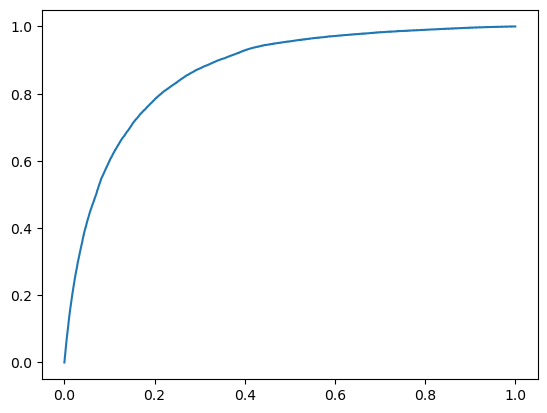

In [14]:
import matplotlib.pyplot as plt
best_auc=0
for step in tqdm(range(1, max_epoch + 1),total=max_epoch,dynamic_ncols=True):
    if step > 1 and config.lr[step - 1] != config.lr[step - 2]:
        for param_group in optimizer.param_groups:
            param_group["lr"] = config.lr[step - 1]

    if (step - 1) % len(train_nloader) == 0:
        loadern_iter = iter(train_nloader)

    if (step - 1) % len(train_aloader) == 0:
        loadera_iter = iter(train_aloader)

    train(loadern_iter, loadera_iter, model,32, optimizer, viz, device)

    #if step % 5 == 0 and step > 0:

    auc,fpr,tpr = test(test_loader, model, viz, device)
    print(auc)
    if auc>best_auc:
        best_auc=auc
        bestfpr=fpr
        besttpr=tpr
    test_info["epoch"].append(step)
    test_info["test_AUC"].append(auc)
        
    if test_info["test_AUC"][-1] > best_AUC:
        best_AUC = test_info["test_AUC"][-1]
        torch.save(model.state_dict(), './ckpt/' +model_name + '{}-i3d.pkl'.format(step))
        save_best_record(test_info, os.path.join(output_path, '{}-step-AUC.txt'.format(step)))
torch.save(model.state_dict(), './ckpt/' + model_name + 'final.pkl')

plt.plot(bestfpr,besttpr)
plt.show()




In [15]:
print(best_auc)

0.8684310299535729


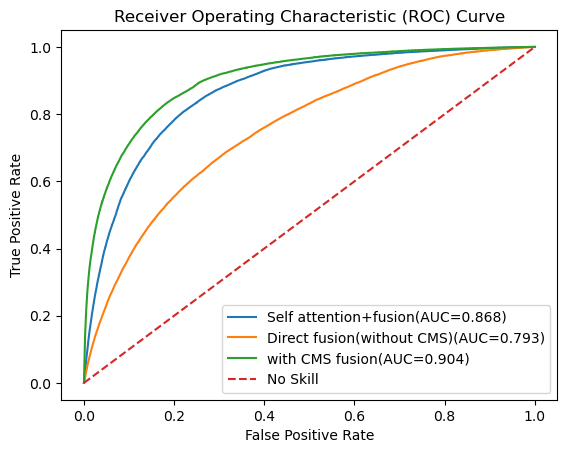

In [16]:
import matplotlib.pyplot as plt


# Plotting the first ROC curve
plt.plot(bestfpr, besttpr, label='Self attention+fusion(AUC=0.868)')

# Plotting the second ROC curve
bestfpr1=np.load(r"C:\Users\karth\Downloads\worstfpr.npy")
besttpr1=np.load(r"C:\Users\karth\Downloads\worsttpr.npy")
plt.plot(bestfpr1, besttpr1, label='Direct fusion(without CMS)(AUC=0.793)')

bestfpr2=np.load(r"C:\Users\karth\Downloads\bestfpr.npy")
besttpr2=np.load(r"C:\Users\karth\Downloads\besttpr.npy")
plt.plot(bestfpr2, besttpr2, label='with CMS fusion(AUC=0.904)')


# Plotting the "no skill" line (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [46]:
import numpy as np
import os
import cv2

clip_len = 16

# the dir of testing images
video_root =  r"C:\Users\karth\Downloads\videos\v=u5SF4SlqNDQ__#00-00-00_00-01-00_label_G-0-0.mp4" ## the path of test videos
feature_list = r'C:\Users\karth\Downloads\XDVioDet-master\XDVioDet-master\list\temptestlist.lst'
# the ground truth txt

gt_txt = r"C:\Users\karth\Downloads\annotations.txt"     ## the path of test annotations
gt_lines = list(open(gt_txt))
gt = []
lists = list(open(feature_list))
tlens = 0
vlens = 0

name = lists[0].strip('\n').split('/')[-1]
cap = cv2.VideoCapture(video_root)
lens = int(cap.get(7))

    # the number of testing images in this sub-dir

gt_vec = np.zeros(lens).astype(np.float32)
for gt_line in gt_lines:
    if name in gt_line:
        gt_content = gt_line.strip('\n').split()
        abnormal_fragment = [[int(gt_content[i]),int(gt_content[j])] for i in range(1,len(gt_content),2) \
                                        for j in range(2,len(gt_content),2) if j==i+1]
        if len(abnormal_fragment) != 0:
            abnormal_fragment = np.array(abnormal_fragment)
            for frag in abnormal_fragment:
                gt_vec[frag[0]:frag[1]]=1.0
    break
mod = (lens-1) % clip_len # minusing 1 is to align flow  rgb: minusing 1 when extracting features
gt_vec = gt_vec[:-1]
if mod:
    gt_vec = gt_vec[:-mod]
    gt.extend(gt_vec)
if sum(gt_vec)/len(gt_vec):
    tlens += len(gt_vec)
    vlens += sum(gt_vec)


np.save('rgt.npy', gt)

<function matplotlib.pyplot.show(close=None, block=None)>

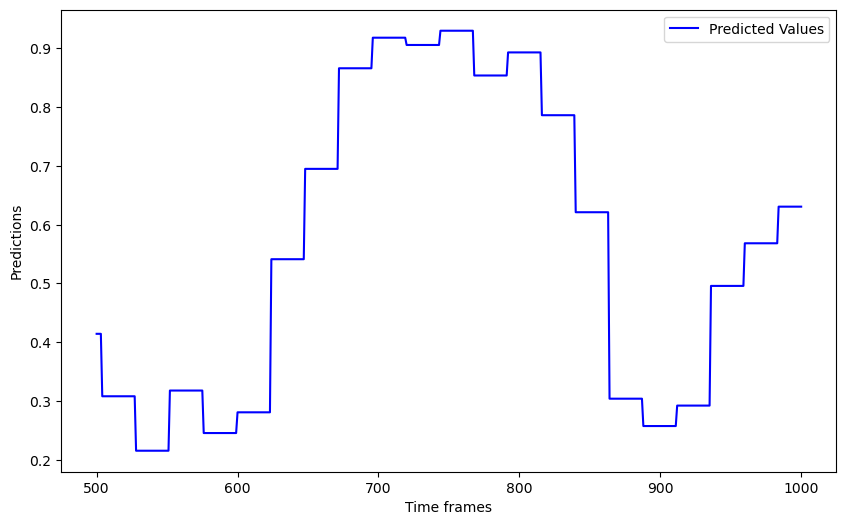

In [73]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import cv2

# # Path to your video file
# video_path = r"C:\Users\karth\Downloads\v=u5SF4SlqNDQ__#00-00-00_00-01-00_label_G-0-0.mp4"

# # Define the time range
# start_time = 30  # Start time for extraction
# end_time = 60   # End time for extraction

# # Open the video file
# video_capture = cv2.VideoCapture(video_path)

# # Get the frame rate of the video
# fps = video_capture.get(cv2.CAP_PROP_FPS)

#print(fps)
# Set the start and end frame indices based on the time range
# start_frame = int(start_time * fps)
# end_frame = int(end_time * fps)

# # Set the current frame position to the start frame
# video_capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# # List to store image paths
# video_frames = []

# # Iterate through the frames and save the required frames
# frame_number = start_frame
# while frame_number < end_frame:
#     # Read the frame
#     ret, frame = video_capture.read()

#     # Save the frame as an image
#     image_filename = f'frame_{frame_number}.jpg'
#     cv2.imwrite(image_filename, frame)

#     # Append the image filename to the list
#     video_frames.append(image_filename)

#     # Increment the frame number
#     frame_number += 1

# # Release the video capture object
#video_capture.release()


gtforvid=np.load(r"C:\Users\karth\Downloads\rgt.npy")
test_loader = DataLoader(Dataset( test_mode=True,is_normal=True),
                              batch_size=1, shuffle=False,
                              num_workers=0, pin_memory=False)

model_path = r"C:\Users\karth\Downloads\ckptmid\rtfm249-i3d.pkl"

model.load_state_dict(torch.load(model_path))

predicted_values = test(test_loader, model, viz, device)
listgt=list(gtforvid)

# Assuming 'predicted_values' is a list of predicted values (y-axis data)
# Assuming 'anomaly_segments' is a list of tuples indicating anomaly segments [(start_time1, end_time1), (start_time2, end_time2), ...]
# Assuming 'video_frames' is a list of image paths corresponding to time frames

# Plotting predicted values vs. time
time_frames=range(500,1001)
anomaly_positions=[]
for i in range(len(listgt)):
    if listgt[i]==1:
        anomaly_positions.append(i)

listgt=listgt[500:1001]


# Prepare data for plotting
predicted_values_within_range = predicted_values[500:1001]

# Plotting predicted values vs. time range
plt.figure(figsize=(10, 6))
plt.plot(time_frames,predicted_values_within_range, label='Predicted Values',color='blue')
#plt.fill_between(time_frames,0,listgt,where=[i in anomaly_positions for i in range(len(time_frames))],color='red',alpha=0.3,label='Ground Truth(Anomaly)')


# normal_img_left=mpimg.imread(r"C:\Users\karth\Downloads\frame_1300.jpg")
# normal_img_right=mpimg.imread(r"C:\Users\karth\Downloads\frame_1350.jpg")
# anomaly_img=mpimg.imread(r"C:\Users\karth\Downloads\frame_1330.jpg")

# plt.axes([0.1,0.7,0.2,0.2])
# plt.imshow(normal_img_left)
# plt.axis('off')

# plt.axes([0.4,0.7,0.2,0.2])
# plt.imshow(anomaly_img)
# plt.axis('off')

# plt.axes([0.7,0.7,0.2,0.2])
# plt.imshow(normal_img_right)
# plt.axis('off')

plt.xlabel('Time frames')
plt.ylabel('Predictions')
plt.legend()
plt.show


In [66]:
gtforvid=np.load(r"C:\Users\karth\Downloads\rgt.npy")

for i in gtforvid:
    if i==1:
        print(i)

gt=[]
for i in range(1441):
    if i>=500 and i<1001:
        if i>=624 and i<=912:
            gt.append(1)
        else:
            gt.append(0)

print(gt)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

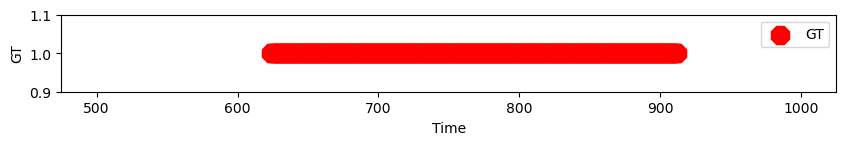

In [77]:
time_frames=range(500,1001)

plt.figure(figsize=(10, 1))

plt.scatter(time_frames,gt,label='GT',color='red',s=200,marker='8')
plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.ylim(0.9,1.1)
plt.show()


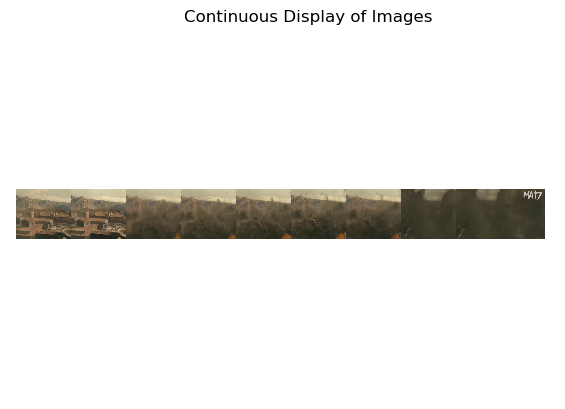

In [78]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# Paths to your 10 image files
image_paths = [
    r"C:\Users\karth\Downloads\frame_1300.jpg",
    r"C:\Users\karth\Downloads\frame_1301.jpg",
    r"C:\Users\karth\Downloads\frame_1330.jpg",
    r"C:\Users\karth\Downloads\frame_1331.jpg",
    r"C:\Users\karth\Downloads\frame_1332.jpg",
    r"C:\Users\karth\Downloads\frame_1333.jpg",
    r"C:\Users\karth\Downloads\frame_1334.jpg",
    r"C:\Users\karth\Downloads\frame_1350.jpg",
    r"C:\Users\karth\Downloads\frame_1351.jpg",

]

# Create a figure and axis
fig, ax = plt.subplots()

# Set limits for x-axis and y-axis
ax.set_xlim(0, len(image_paths))  # Adjust if needed
ax.set_ylim(0, 1)  # Adjust if needed

# Display images along the x-axis
for i, path in enumerate(image_paths):
    img = Image.open(path)
    imagebox = OffsetImage(img, zoom=0.1)  # Adjust the zoom factor as needed
    ab = AnnotationBbox(imagebox, (i, 0.5), frameon=False)
    ax.add_artist(ab)

# Hide x and y axis labels
ax.axis('off')

plt.title('Continuous Display of Images')
plt.show()
